# tsGT Example - Flax/JAX Version

This is an adapted example notebook for the migrated tsGT codebase (Trax → Flax/JAX).

## Changes from original:
- Uses `optax` instead of `trax.optimizers`
- Uses Flax Linen modules instead of Trax layers
- Updated trainer API returning `TrainState` instead of `TrainingLoop`
- Updated simulations API

In [ ]:
# Install dependencies if needed
# !pip install jax jaxlib flax optax gin-config gymnasium pandas matplotlib tqdm scikit-learn scipy seaborn

In [1]:
import functools
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

print(f"JAX version: {jax.__version__}")
print(f"Available devices: {jax.devices()}")

JAX version: 0.6.2


Available devices: [CpuDevice(id=0)]


In [2]:
# Import project modules
import datasets as ds  # Renamed to avoid collision with datasets list
import inputs
import models
import trainer
import serial_predictor
import distribution_predictor
import iqn_predictor
import simulations
import normalization

# Example time series data

We generate simple sine wave data with different frequencies.

In [3]:
from itertools import cycle
import random

# Configuration
start_date = pd.Timestamp('2018-01-01 18:30:00')
periods = 200
train_window = 40
eval_window = 10
series_length = 20
freq = '1H'

def prepare_example_data(periods, start_date, freq) -> pd.DataFrame:
    """Generate sine wave time series data."""
    t = np.linspace(0, 5 * np.pi, periods)
    frequencies = [0.5, 1, 1.5, 2]
    sine_waves = [np.sin(f * t) for f in frequencies]
    df = pd.DataFrame(sine_waves).T
    df.index = pd.date_range(start_date, periods=periods, freq=freq)
    df.index.name = 'date'
    return df

df = prepare_example_data(periods=periods, start_date=start_date, freq=freq)

def get_list(df, train_window, eval_window, steps, freq):
    """Get list of window start dates."""
    start_date = df.index.min()
    end_date = df.index.max() - pd.Timedelta(freq) * (train_window + eval_window)
    delta = ((end_date - start_date) / (steps - 1)).floor(freq)
    return [start_date + i * delta for i in range(steps)]

window_starts = get_list(df, train_window, eval_window, steps=3, freq=freq)
print(f"Data shape: {df.shape}")
print(f"Window starts: {window_starts}")

Data shape: (200, 4)
Window starts: [Timestamp('2018-01-01 18:30:00'), Timestamp('2018-01-04 20:30:00'), Timestamp('2018-01-07 22:30:00')]


/tmp/ipykernel_72/438714421.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.index = pd.date_range(start_date, periods=periods, freq=freq)
/tmp/ipykernel_72/438714421.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  end_date = df.index.max() - pd.Timedelta(freq) * (train_window + eval_window)
/tmp/ipykernel_72/438714421.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  delta = ((end_date - start_date) / (steps - 1)).floor(freq)


/tmp/ipykernel_72/3032200114.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  unit = pd.Timedelta(freq)


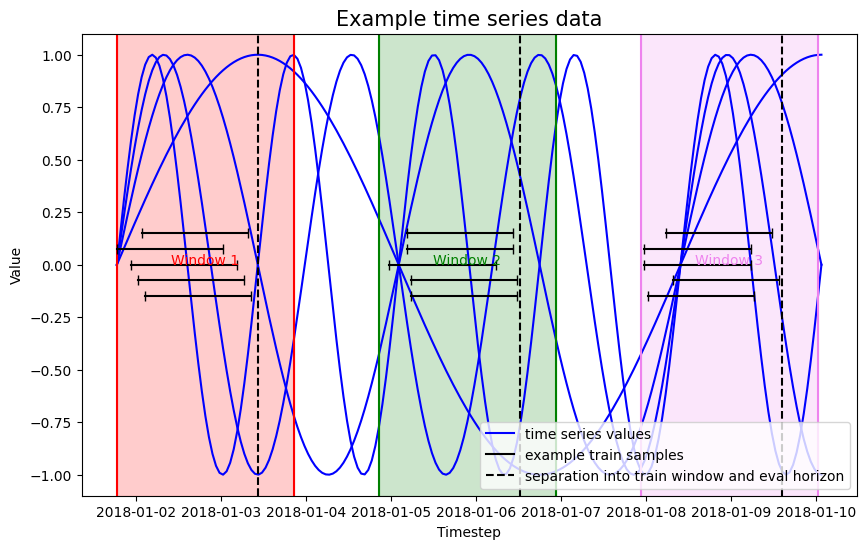

In [4]:
#################
# Visualization #
#################

plt.figure(figsize=(10, 6))
for column in df.columns:
    plt.plot(df.index, df[column], color='blue')

unit = pd.Timedelta(freq)
for i, (start, color) in enumerate(zip(window_starts, cycle(["red", "green", "violet"]))):
    plt.axvline(start, color=color, linestyle='-')
    plt.axvline(start + unit * (train_window), color='black', linestyle='--')
    plt.axvline(start + unit * (train_window + eval_window), color=color, linestyle='-')
    plt.axvspan(start, start + unit * (train_window + eval_window), color=color, alpha=0.2)
    plt.text(start + unit * (train_window + eval_window) / 2, 0, f'Window {i + 1}', color=color, ha='center')

    # plot example train samples
    for j in np.linspace(-0.15, 0.15, 5):
        r = random.randint(0, train_window - series_length - eval_window)
        r = unit * r + start      
        plt.plot([r, r + unit * (series_length + eval_window)], [j, j], color='black')
        plt.plot(r, j, marker='|', color='black', markersize=7)
        plt.plot(r + unit * (series_length + eval_window), j, marker='|', color='black', markersize=7)

plt.title('Example time series data', size=15)
plt.xlabel('Timestep', size=10)
plt.ylabel('Value', size=10)

plt.plot([], [], color='blue', label="time series values")
plt.plot([], [], color='black', label="example train samples")
plt.plot([], [], color='black', linestyle='--', label="separation into train window and eval horizon")

plt.legend(loc='lower right')
plt.show()

# Dataset and loader

Create Dataset objects and input pipelines.

In [5]:
# Create datasets for each time window
datasets_list = [
    ds.Dataset(
        data_full=ds.DataCollection(data_loader=lambda df=df: df),
        start_date=pd.Timestamp(window_start),
        train_window=train_window,
        eval_window=eval_window,
        series_length=series_length,
    ) for window_start in window_starts
]

# Create input functions for each dataset
inputs_fns = [
    functools.partial(
        inputs.CreateInputs,
        dataset=dataset,
        batch_size=4,
        series_length=series_length,
        weighted_sampling=True,
    ) for dataset in datasets_list
]

print(f"Created {len(datasets_list)} datasets")

Created 3 datasets


In [6]:
# Test data loading
test_inputs = inputs_fns[0]()
test_batch = next(test_inputs.train_batches())
print(f"Batch shapes:")
print(f"  Series: {test_batch[0].shape}")
print(f"  Inputs: {test_batch[1].shape}")
print(f"  Targets: {test_batch[2].shape}")
print(f"  Masks: {test_batch[3].shape}")

Batch shapes:
  Series: (4, 20)
  Inputs: (4, 20, 4)
  Targets: (4, 20)
  Masks: (4, 20)


# Model and predictor

Define the transformer model body and predictor class.

In [7]:
# Define model body
# Note: Changed from 'dropout' to 'dropout_rate' in the new codebase
model_body_fn = functools.partial(
    models.TransformerBody,
    d_model=64,
    n_layers=2,
    n_heads=2,
    max_len=100,
    dropout_rate=0.1,
)

# Use SerialPredictor for discretized time series modeling
predictor_cls = functools.partial(
    serial_predictor.SerialPredictor,
    model_body_fn=model_body_fn,
    d_in=64,  # Match d_model
    vocab_size=64,
    precision=3,
    significance_decay=0.7,
    low=-1.0,  # Sine waves range from -1 to 1
    high=1.0,
    normalization="per_ts",
    normalization_regularizer=1.0,
)

print("Model and predictor configured")

Model and predictor configured


# Training

Train the model for a few iterations.

**Note:** The new trainer API returns `(state, history)` instead of a `TrainingLoop` object.

In [8]:
import os
os.makedirs('./out', exist_ok=True)

# Train on the first dataset as a test
print("Testing training on first dataset...")

# Create a predictor instance
predictor = predictor_cls()

# Get input function
inputs_fn = functools.partial(inputs_fns[0], full_eval=False)

# Call before_training to fit serializer
predictor.before_training(inputs_fn)

print("Serializer fitted successfully!")

Testing training on first dataset...
Serializer fitted successfully!


In [9]:
# Train the model using the new trainer
# Note: The trainer in the new codebase uses a slightly different API

# For this example, we'll do a simplified training loop
from flax.training import train_state
import time

def simple_train(
    inputs_fn,
    predictor,
    n_steps=100,
    learning_rate=0.001,
):
    """Simple training loop for demonstration."""
    # Get a sample batch to determine shapes
    inp = inputs_fn()
    sample_batch = next(inp.train_batches())
    series, inputs_data, targets, mask = sample_batch
    
    # Create training model
    train_model = predictor.make_train_eval_model('train')
    
    # Initialize model
    rng = jax.random.key(42)
    rng, init_rng = jax.random.split(rng)
    
    # Convert to JAX arrays
    series_j = jnp.array(series)
    inputs_j = jnp.array(inputs_data)
    targets_j = jnp.array(targets)
    mask_j = jnp.array(mask)
    
    # Initialize
    variables = train_model.init(
        {'params': init_rng, 'dropout': init_rng},
        series_j, inputs_j, targets_j, mask_j, 
        predictor.normalizer,
        deterministic=True
    )
    params = variables['params']
    
    # Count parameters
    param_count = sum(p.size for p in jax.tree_util.tree_leaves(params))
    print(f"Model has {param_count:,} parameters")
    
    # Create optimizer
    tx = optax.adam(learning_rate)
    opt_state = tx.init(params)
    
    # Loss function
    loss_fn_base = predictor.make_loss()
    
    def loss_fn(params, batch, rng):
        series_b, inputs_b, targets_b, mask_b = batch
        logits, target_repr, weights = train_model.apply(
            {'params': params},
            series_b, inputs_b, targets_b, mask_b,
            predictor.normalizer,
            deterministic=False,
            rngs={'dropout': rng}
        )
        return loss_fn_base(logits, target_repr, weights)
    
    # Training step
    @jax.jit
    def train_step(params, opt_state, batch, rng):
        loss, grads = jax.value_and_grad(loss_fn)(params, batch, rng)
        updates, opt_state = tx.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss
    
    # Training loop
    print(f"Training for {n_steps} steps...")
    start_time = time.time()
    losses = []
    
    train_gen = inp.train_batches()
    for step in range(1, n_steps + 1):
        try:
            batch = next(train_gen)
        except StopIteration:
            train_gen = inp.train_batches()
            batch = next(train_gen)
        
        batch = tuple(jnp.array(b) for b in batch)
        rng, step_rng = jax.random.split(rng)
        params, opt_state, loss = train_step(params, opt_state, batch, step_rng)
        losses.append(float(loss))
        
        if step % 10 == 0 or step == 1:
            print(f"  Step {step}/{n_steps} | Loss: {loss:.4f}")
    
    elapsed = time.time() - start_time
    print(f"Training complete in {elapsed:.1f}s")
    
    return {'params': params}, losses

# Train on first dataset
weights, losses = simple_train(
    inputs_fn=inputs_fns[0],
    predictor=predictor,
    n_steps=50,
    learning_rate=0.001,
)

TypeError: SerialTrainingModel.__call__() missing 1 required positional argument: 'normalizer'

In [13]:
# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'losses' is not defined

<Figure size 800x400 with 0 Axes>

# Prediction Test

Test the trained model's prediction capability.

In [10]:
# Test prediction
eval_inputs = inputs_fns[0](full_eval=True)
eval_batch = next(eval_inputs.eval_batches())
series, inp_data, targets, mask = eval_batch

# Get context (non-masked portion)
horizon = int(mask[0].sum())
context_length = series.shape[1] - horizon
context = series[:, :context_length]

print(f"Context shape: {context.shape}")
print(f"Horizon: {horizon}")
print(f"Inputs shape: {inp_data.shape}")

Context shape: (4, 10)
Horizon: 10
Inputs shape: (4, 20, 4)


In [11]:
# Make predictions (this may take a moment)
print("Making predictions...")
try:
    predictions = predictor.predict(
        weights=weights,
        context=context[:1],  # Just predict one series
        inputs=inp_data[:1],
        horizon_length=horizon,
    )
    print(f"Predictions shape: {predictions.shape}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    full_series = series[0]
    plt.plot(range(len(full_series)), full_series, 'b-', label='Ground truth')
    plt.plot(range(context_length, len(full_series)), predictions[0], 'r--', label='Prediction')
    plt.axvline(context_length, color='gray', linestyle=':', label='Forecast start')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.title('Time Series Prediction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print(f"Prediction error (may need more training): {e}")

Making predictions...
Prediction error (may need more training): name 'weights' is not defined


# Alternative: Distribution Predictor

You can also use the DistributionPredictor for continuous output.

In [12]:
# Distribution predictor example
dist_predictor_cls = functools.partial(
    distribution_predictor.DistributionPredictor,
    model_body_fn=model_body_fn,
    d_in=64,
    normalization="per_ts",
    distribution="gaussian",  # Can be 'gaussian', 'laplace', 'cauchy', 'tstudent'
    learn_scale="shared",
)

dist_predictor = dist_predictor_cls()
print(f"Distribution predictor created")
print(f"Distribution: {dist_predictor.distribution}")
print(f"Output size (# params): {dist_predictor.output_size}")

Distribution predictor created
Distribution: <distributions.Gaussian object at 0x7fa7ecb6b8e0>
Output size (# params): 2


# Summary

This notebook demonstrates the migrated tsGT codebase with:

1. **Data loading**: Using `datasets.Dataset` and `inputs.CreateInputs`
2. **Model definition**: Using Flax `models.TransformerBody`
3. **Predictors**: 
   - `SerialPredictor` - discretizes time series into tokens
   - `DistributionPredictor` - outputs continuous distributions
   - `IQNPredictor` - implicit quantile networks
4. **Training**: Using JAX/Optax instead of Trax
5. **Prediction**: Autoregressive sampling with cached attention

Key differences from the Trax version:
- Use `optax` for optimizers
- Models are Flax Linen modules
- Training state is managed differently
- JIT compilation uses `jax.jit` directly

In [ ]:
# Cleanup
print("Example complete!")